In [1]:
from io import open
import glob 
import os

We enumerate files in the `data` folder.

In [2]:
def findFiles(path):
    return glob.glob(path)

print(findFiles("data/names/*.txt"))

['data/names/Spanish.txt', 'data/names/Czech.txt', 'data/names/Russian.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Greek.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/Chinese.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Japanese.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt', 'data/names/Dutch.txt', 'data/names/German.txt']


To simply our task, we "regularize" the names and, say, turn à to a.

In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " ,.;"
n_letters = len(all_letters)

"""
Remove symbols like accent. For example Ś is turned into S.
"""
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

unicodeToAscii("Ślusàrski")

'Slusarski'

Read the data files and regularize the names.

In [4]:
# Build the category_lines dictionary, a list of names per language
# all_categories: a list of "categories" i.e. languages
# category_lines: a map from language names to person names in these languages;
#   the word "lines" is used because in the sample files, each name is a line.
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    # Separate the name of the language from the path:
    # for example from "data/names/Chinese.txt" to "Chinese"
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
print(all_categories)
print(category_lines['Italian'][:5])

['Spanish', 'Czech', 'Russian', 'Italian', 'Portuguese', 'Scottish', 'Greek', 'English', 'French', 'Chinese', 'Irish', 'Arabic', 'Korean', 'Japanese', 'Vietnamese', 'Polish', 'Dutch', 'German']
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Embedding

For a RNN, each letter is fed to one RNN cell, and one RNN cell is just a neural network,
so (the embedding of) each letter should have the shape of `(1, the_true_size)`.

In [6]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0, letterToIndex(letter)] = 1.0
    return tensor

letterToTensor("J")


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [7]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for idx, letter in enumerate(line):
        tensor[idx, 0, letterToIndex(letter)] = 1.0
    return tensor

lineToTensor("Jeff")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0

# Defining the neural network

In [8]:
import torch.nn as nn 
import torch.nn.functional as F

class NameClassifyRNN(nn.Module):
    """
    `input_size` here is the size of the one-shot vector representing a single letter, 
    not the length of the word.

    `output_size` is the number of languages.
    """
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    """
    Map `(input, hidden)` to `(output, hidden)`.
    """
    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.softmax(self.h2o(hidden))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [38]:
n_hidden = 128
rnn = NameClassifyRNN(n_letters, n_hidden, n_categories)

Sanity check.

In [23]:
input = letterToTensor("A")
init_hidden = rnn.initHidden()
output, next_hidden = rnn(input, init_hidden)

In [24]:
input = lineToTensor("Albert")
init_hidden = rnn.initHidden()
output, next_hidden = rnn(input[0], init_hidden)

Some converting functions.

In [25]:
def outputToCategory(output):
    _, top_i = output.topk(1)
    category_idx = top_i[0].item()
    return all_categories[category_idx], category_idx

outputToCategory(output)

('Russian', 2)

# Training infrastructure

In [26]:
import random

"""
Randomly pick up one element in `l`.
"""
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [27]:
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [31]:
learning_rate = 0.005

criterion = nn.NLLLoss()

def pred(line):
    line_tensor = lineToTensor(line)
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)        
        
    return outputToCategory(output)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor) 
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

# Training

In [39]:
import time
import math

n_iters = 200000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = outputToCategory(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%7d %2d%% (%8s) %6.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

   5000  2% (   0m 5s) 2.4956 Gibson / Russian ✗ (Scottish)
  10000  5% (   0m 9s) 1.2151 Meeuwsen / Dutch ✓
  15000  7% (  0m 14s) 3.0248 Walters / Dutch ✗ (English)
  20000 10% (  0m 18s) 1.3001 Bohler / German ✓
  25000 12% (  0m 23s) 2.6013 Denend / Scottish ✗ (Dutch)
  30000 15% (  0m 27s) 2.6097 Smith / Irish ✗ (Scottish)
  35000 17% (  0m 31s) 0.3714 Pantelas / Greek ✓
  40000 20% (  0m 36s) 1.5156 Lian / Irish ✗ (Chinese)
  45000 22% (  0m 40s) 0.3550 Napoletani / Italian ✓
  50000 25% (  0m 45s) 1.4112 Spence / English ✓
  55000 27% (  0m 49s) 0.3078 Paterson / Scottish ✓
  60000 30% (  0m 54s) 0.7178 Gutermuth / German ✓
  65000 32% (  0m 58s) 1.5128 Tchekvin / German ✗ (Russian)
  70000 35% (   1m 3s) 0.7634 Rebka / Polish ✗ (Czech)
  75000 37% (   1m 7s) 0.0854 Mccallum / Scottish ✓
  80000 40% (  1m 11s) 0.2064 Mifsud / Arabic ✓
  85000 42% (  1m 16s) 4.0456 DanShin / Irish ✗ (Russian)
  90000 45% (  1m 20s) 0.6208 Mercier / French ✓
  95000 47% (  1m 25s) 0.1828 Sheludko 

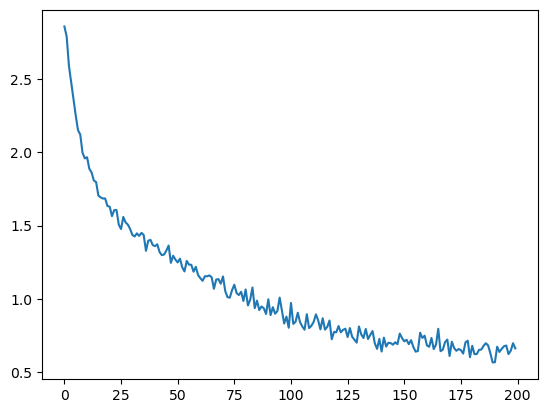

In [40]:
import matplotlib.pyplot as plt 
plt.plot(all_losses)

# Testing

In [47]:
pred("Smith")

('Czech', 1)

In [1]:
enumerate(category_lines)

NameError: name 'category_lines' is not defined